## Import FashionMnist Dataset

In [1]:
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

class FashionMNIST(torchvision.datasets.MNIST):
    '''
      Args:
        root (string): Root directory of dataset where ``processed/training.pt``
            and  ``processed/test.pt`` exist.
        train (bool, optional): If True, creates dataset from ``training.pt``,
            otherwise from ``test.pt``.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    '''
    urls = [
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz',
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz',
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz',
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz',
    ]

train_data = FashionMNIST(
    root='./FashionMnist', #保存位置
    train=True, #training set
    transform=torchvision.transforms.ToTensor(), #converts a PIL.Image to torch.FloatTensor(C*H*W) in range(0.0,1.0)
    download=True
)
test_data = FashionMNIST(
    root='./FashionMnist',
    train=False,
    transform=torchvision.transforms.ToTensor()
)

In [2]:
len(train_data)

60000

## training process 4-layer MLP 

In [11]:
from torch.nn.utils import clip_grad_norm
from math import ceil
import copy


# main function
def train(batchsize,learning_rate):
    torch.manual_seed(123) #reproducible

    EPOCH = 200
    BATCH_SIZE = batchsize
    
    # make data iterable
    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE,shuffle=False)
    num_iters = EPOCH*len(train_loader)
   
    distance = np.zeros(EPOCH+1)
    covar = np.zeros(EPOCH+1)

    # 4-layer batch_normalization MLP neural network model structure
    class cnn_model(nn.Module):

        def __init__(self):
            '''
            super(MLP4_model, self).__init__()
            self.layers = nn.Sequential(
                nn.Linear(28 * 28, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(True),
                nn.Linear(512, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(True),
                nn.Linear(512, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(True),
                nn.Linear(512, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(True),
                nn.Linear(512, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(True),
                nn.Linear(512, 10),
            )
        def forward(self, inputs):
            return self.layers(inputs.view(inputs.size(0), -1))
        '''
        def __init__(self):
            super(cnn_model, self).__init__()
            self.fc1 = nn.Linear(28*28,512)
            torch.nn.init.normal(self.fc1.weight, mean=0, std=0.03)
            #nn.init.xavier_normal(self.fc1.weight,gain = 1)
            nn.init.constant(self.fc1.bias, 0.1)
        
            self.fc2 = nn.Linear(512,10)
            torch.nn.init.normal(self.fc2.weight, mean=0, std=0.3)
            #nn.init.xavier_normal(self.fc2.weight, gain = 1)
            nn.init.constant(self.fc2.bias, 0.1)
           # self.out = nn.Linear(10,10)
        
        def forward(self, x):
            x = x.view(-1, 784)
            x = F.relu(self.fc1(x))
            x = F.softmax(self.fc2(x))
            output = x
            #output = self.out(x)
            return output

    #loss function and opimizer    
    model = cnn_model()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,weight_decay= 1e-4, momentum=0.9)
    loss_func = nn.CrossEntropyLoss()
    
    #initial weight value
    init_weights = [w.data.cpu().clone() for w in list(model.parameters())]
    
    #train process
    for epoch in range(EPOCH):
    
        #adjust_learning_rate(optimizer,epoch, batchsize)
        noise_sum_a = 0.0
        
        for i, data in enumerate(train_loader,0):
            
            #get the inputs
            inputs, labels = data

            #wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)
            
            #chunk batch samples into one samples
            mini_inputs = inputs.chunk(batchsize // 2)
            mini_targets = labels.chunk(batchsize // 2)
            
            #clean grad to zero
            optimizer.zero_grad()
            
            print("done")
            
            #compute each sample output by CNN models
            batch_params_list = []
            
            for k, mini_input_var in enumerate(mini_inputs,0):
                
                mini_target_var = mini_targets[k]
                output = model(mini_input_var)
                loss = loss_func(output, mini_target_var)
                loss.backward()
                
                params = []
                
                for param in model.parameters():
                    
                    temp_param = param.grad.data.clone()
                    
                    params.append(temp_param)
            
               # print(params,k)
                batch_params_list.append(params)
                optimizer.zero_grad()
            
            #for p, sample_i in enumerate(batch_params_list,0):
            #        print(sample_i[2][9][9])
            
            #calculate covariance
            
            params = list(model.parameters())
            noise = np.zeros(len(params))
            
            #print("%d",(len(params)))
            
            for k in range(0,len(params)):
                I1 = torch.zeros(params[k].size()[0],params[k].size()[0])
                I2 = torch.zeros(params[k].size()[0],params[k].size()[0])
                for p, sample_i_params in enumerate(batch_params_list,0):
                    for q, sample_j_params in enumerate(batch_params_list,0):
                            #print("%d %d %d",i,j,k)
                            n = sample_i_params[k].dim()
                            if(n == 1):
                                temp_i = torch.randn(params[k].size()[0],1)
                                temp_j = torch.randn(params[k].size()[0],1)
                                for m in range(0,n):
                                    temp_i[m] = sample_i_params[k][m]
                                    temp_j[m] = sample_j_params[k][m]
                                
                                if p == q:
                                        I1 += temp_i.mm(temp_j.transpose(0,1))
                                if p != q:
                                        I2 += temp_i.mm(temp_j.transpose(0,1))                              
                            else:
                                if p==q:
                                    I1 += sample_i_params[k].mm(sample_j_params[k].transpose(0,1))
                                if p!=q:
                                    I2 += sample_i_params[k].mm(sample_j_params[k].transpose(0,1))
            
                covarience = 1.0/BATCH_SIZE*(1-BATCH_SIZE/len(train_data))*(1.0/len(train_data)*I1-1.0/(len(train_data)*(len(train_data)-1))*I2)
                noise[k] = covarience.trace()
            
            noise_sum = np.sum(noise)
            print(noise_sum,i)
            
            #using CNN compute output
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            #optimizer.zero_grad()
            loss.backward()
            
            
            clip_grad_norm(model.parameters(), 5.)     # clip grad avoding grad explosion
            optimizer.step()
            
            if i==0 and epoch==0: 
                step_dist = 0
                for k, w in enumerate(model.parameters()):  
                    #if k in idxs :    
                    step_dist +=  (w.data.cpu() - init_weights[k]).norm()
                print('%d %d step_dist:%f covarience:%f'%(i+1,epoch+1,step_dist,noise_sum))
                distance[i] = step_dist
                covar[i] = noise_sum
           
            if (i+1)%len(train_loader) ==0:
                step_dist = 0
                for k, w in enumerate(model.parameters()):  
                    #if k in idxs :    
                    step_dist +=  (w.data.cpu() - init_weights[k]).norm()
                print('%d %d step_dist:%f covarience:%f'%(i+1,epoch+1,step_dist,noise_sum))
                distance[epoch+1] = step_dist
                covar[i] = noise_sum
            
    print('Finished Training')
    np.save('cor%d.npy'%BATCH_SIZE,distance)
    np.save('noise%d.npy'%BATCH_SIZE,covar)

In [15]:
x = torch.randn(2,1)
x[0]


-1.3166
[torch.FloatTensor of size 1]

In [77]:
x.size()

torch.Size([2])

In [80]:
y = x.transpose(0,1)
y


 1.1751  1.4597
[torch.FloatTensor of size 1x2]

In [14]:
batchsize = [256]
learning_rate = [0.5]
for i in range(0,len(batchsize)):
    train(batchsize[i],learning_rate[i])

done


/Users/apple/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.000116704938008 0
1 1 step_dist:0.557479 covarience:0.000117
done
0.0002716063476 1
done
0.000100127535846 2
done
1.79537609986e-05 3
done
5.18633594138e-05 4
done
4.52730668351e-05 5
done
4.04824587236e-05 6
done
1.96375009488e-05 7
done
3.05036191643e-05 8
done
9.87710189073e-06 9
done
3.22974954538e-05 10
done


KeyboardInterrupt: 

D:\anaconda\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


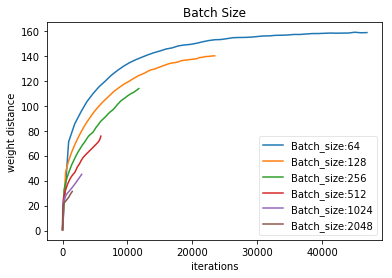

In [77]:
import matplotlib 
from matplotlib.ticker import  MultipleLocator
matplotlib.use('Agg')
BATCH_SIZE1 = 128
distance64 = np.load('disgbn64.npy')
distance128 = np.load('disgbn128.npy')
distance256 = np.load('disgbn256.npy')
distance512 = np.load('disgbn512.npy')
distance1024 = np.load('disgbn1024.npy')
distance2048 = np.load('disgbn2048.npy')
#distance4096 = np.load('distance4096.npy')
x_index64=np.arange(0,50*938+1,938)
x_index128=np.arange(0,50*469+1,469)
x_index256=np.arange(0,50*235+1,235)
x_index512=np.arange(0,50*118+1,118)
x_index1024=np.arange(0,50*59+1,59)
x_index2048=np.arange(0,50*30+1,30)
#x_index4096=np.arange(0,70*15+1,15)

fig = plt.figure()
plt.title("Batch Size")
plt.xlabel('iterations')
plt.ylabel('weight distance')
plt.plot(x_index64,distance64,label='Batch_size:64')
plt.plot(x_index128,distance128,label='Batch_size:128')
plt.plot(x_index256,distance256,label='Batch_size:256')
plt.plot(x_index512,distance512,label='Batch_size:512')
plt.plot(x_index1024,distance1024,label='Batch_size:1024')
plt.plot(x_index2048,distance2048,label='Batch_size:2048')
#plt.plot(x_index4096,distance4096,label='Batch_size:4096')
#plt.axis([-0.1,4,0.0,1.0]) 

#plt.fill_between(x_index,X1,X3,color = 'red',alpha = '0.1')
plt.legend(loc='lower right',framealpha = 0.5)
plt.savefig("batchsize normal.png") 
plt.show()